In [1]:
import pandas as pd
import requests
import csv
import networkx as nx
from networkx.algorithms import community as community
import matplotlib.pyplot as plt
import math
from statistics import median
#import igraph as ig
#from igraph import plot
import itertools
import numpy as np

# 1. API PHASE

In [2]:
import json 
import urllib 
from urllib.parse import urlparse 
import httplib2 as http #External library 

df_bus = []


if __name__=="__main__": 
    headers = { 'AccountKey' : '3CYP10m2Qwe+Ut3NlIAZdg==','accept' : 'application/json'} 
    
    i = 0    
    uri = 'http://datamall2.mytransport.sg/' #Resource URL     
    path = 'ltaodataservice/BusRoutes'
    skip = '?$skip='+str(i)
    target = urlparse(uri + path + skip)
    method = 'GET'     
    body = ''
    h = http.Http()
    
    response, content = h.request(         
            target.geturl(),        
            method,         
            body,         
            headers)
    response_dict = json.loads(content)
   

    while len(response_dict['value'])>0:
        skip = '?$skip='+str(i)
        target = urlparse(uri + path + skip)
         
        #Obtain results     
        response, content = h.request(         
            target.geturl(),        
            method,         
            body,         
            headers)       
        
        response_dict = json.loads(content)
        df = pd.json_normalize(response_dict['value'])
        df_bus.append(df)
        
        i+= 500

df_bus = pd.concat(df_bus, axis=0, ignore_index = True)
df_bus.reset_index()
df_bus.to_csv('final_bus.csv')

df_stops = []

if __name__=="__main__": 
    headers = { 'AccountKey' : '3CYP10m2Qwe+Ut3NlIAZdg==','accept' : 'application/json'} 
    
    i = 0    
    uri = 'http://datamall2.mytransport.sg/' #Resource URL     
    path = 'ltaodataservice/BusStops'
    skip = '?$skip='+str(i)
    target = urlparse(uri + path + skip)
    response, content = h.request(         
            target.geturl(),        
            method,         
            body,         
            headers)
    response_dict = json.loads(content)
   
    while len(response_dict['value'])>0:
        skip = '?$skip='+str(i)
        target = urlparse(uri + path + skip)
        method = 'GET'     
        body = '' 

        h = http.Http()      

        #Obtain results     
        response, content = h.request(         
            target.geturl(),        
            method,         
            body,         
            headers)       
        
        response_dict = json.loads(content)
        df = pd.json_normalize(response_dict['value'])
        df_stops.append(df)
        
        i+= 500

df_stops = pd.concat(df_stops, axis=0, ignore_index = True)
df_stops.head()
df_stops.to_csv('Stop_Names.csv', index=False)
df_busstop = df_stops

# 2. DATA PHASE

For each service number and direction, link the BusStopCode in sequence, e.g. 75009 and 76059, then 76059 and 76069...  <br>  These represent the connections. <br>
You can remove duplicates later on (for parallel bus services). <br>
We can also group by directions...

## 2a. Find the routes

In [3]:
# Find the list of ServiceNos
busnos = list(df_bus['ServiceNo'].unique())

#Create an empty DataFrame to append to
bus_network = pd.DataFrame()
service = []
source = []
target = []

# List of Bus Stops for Direction 1
bus_stops = df_bus[df_bus['Direction']==1]

# List of connected Bus Stops for Direction 1
for x in busnos:
    busstops = list(bus_stops.loc[(bus_stops['ServiceNo']==x)].BusStopCode)
    for i in range(len(busstops)-1):
        service.append(x)
        source.append(busstops[i])
        target.append(busstops[i+1])
        
bus_network['service'] = service
bus_network['source'] = source
bus_network['target'] = target

##  2b. Find the frequency

In [4]:
bus_network_no_dupes = bus_network.drop_duplicates()
bus_network_freq = bus_network_no_dupes.groupby(["source", "target"]).size().reset_index(name="freq")
bus_network_freq.sort_values('freq',ascending=False).head(10)
bus_network_freq = bus_network_freq[['source','target','freq']]
bus_network_freq

source target  freq
0     01012  01112     2
1     01012  01113     2
2     01019  02049     4
3     01019  04159     4
4     01029  04111     2
...     ...    ...   ...
6582  99161  95071     4
6583  99171  99161     4
6584  99181  95131     1
6585  99181  99171     4
6586  99189  99049     3

[6587 rows x 3 columns]

## 2c. Plot the Graph

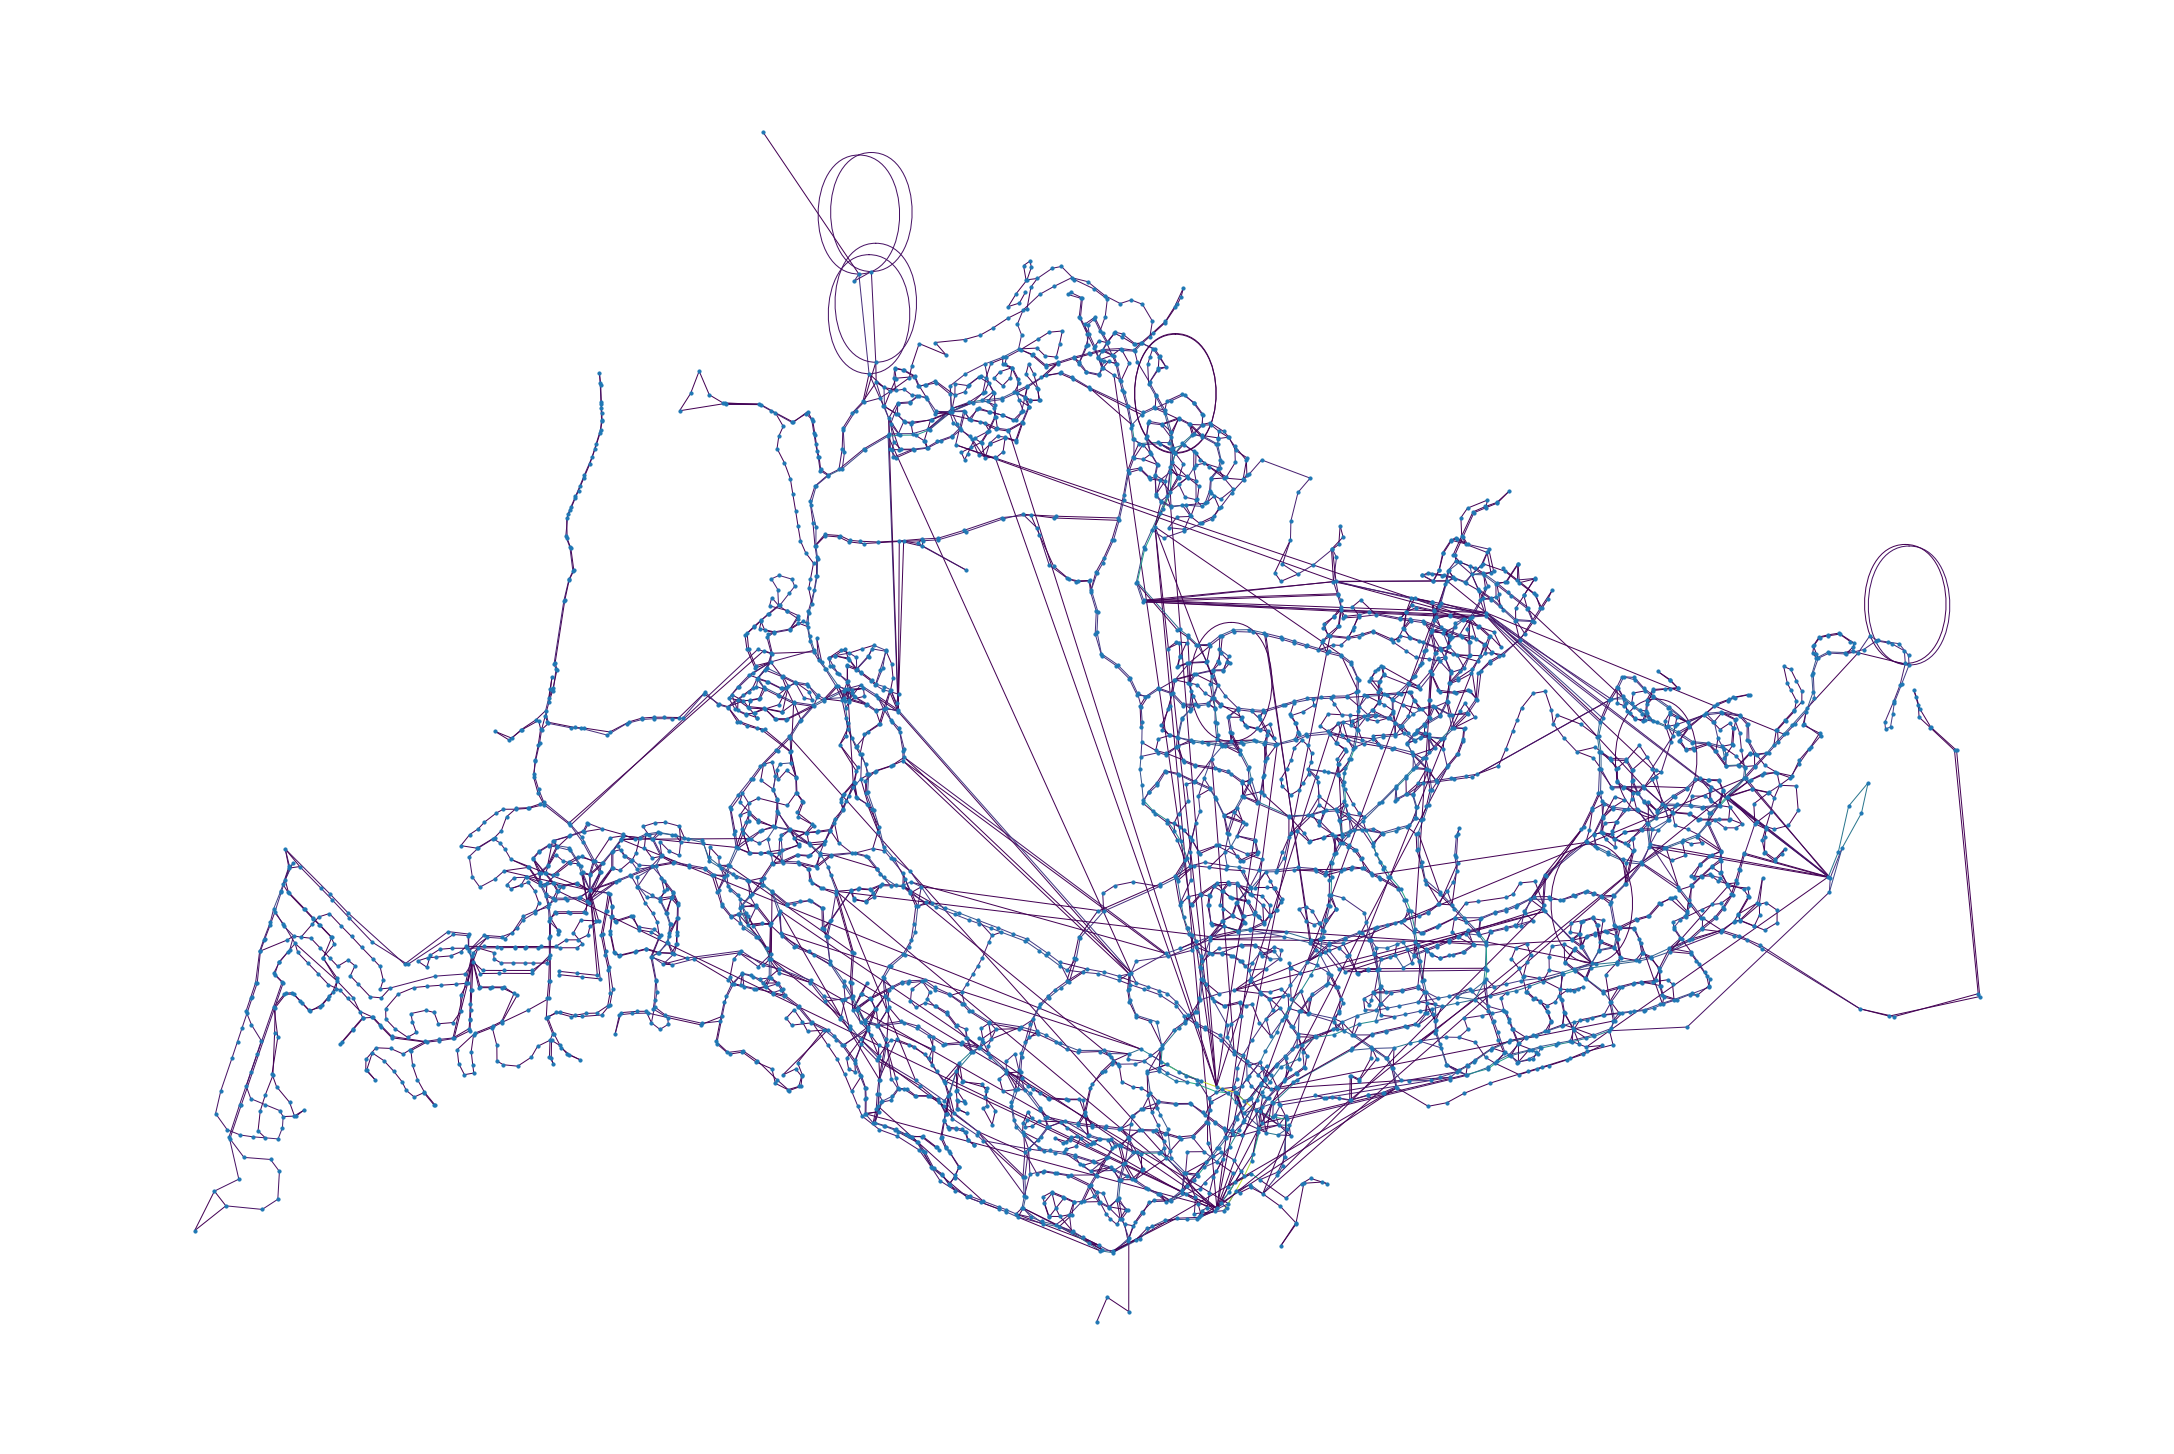

In [5]:
#Put in coordinates
coords = list(zip(df_busstop.Longitude,df_busstop.Latitude)) 
pos = dict(zip(df_busstop['BusStopCode'], coords))

#construct graph
G = nx.Graph()
G.add_nodes_from(bus_network_freq['source'])
G = nx.from_pandas_edgelist(bus_network_freq,'source','target',edge_attr = 'freq')
weights = [d['freq'] for s, t, d in G.edges(data=True)]

#draw graph; note the edges are coloured based on the freq.
plt.figure(figsize=(30,20))
nx.draw(G,pos,node_size = 10,edge_color=weights)

# Scale Free?

22

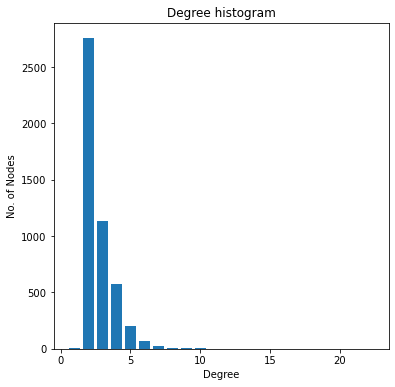

In [7]:
degree_sequence = sorted((d for n, d in G.degree()), reverse=True)
dmax = max(degree_sequence)

fig = plt.figure("Degree of a bus route graph", figsize=(6, 6))

ax2 = fig.add_subplot()
ax2.bar(*np.unique(degree_sequence, return_counts=True))
ax2.set_title("Degree histogram")
ax2.set_xlabel("Degree")
ax2.set_ylabel("No. of Nodes");

dmax

# 3. Metrics

In [7]:
den = nx.density(G)
dia = nx.diameter(G)

print(f'Density: {den}, diameter: {dia}')

Density: 0.0005707818957864074, diameter: 70


# 4. COMMUNITY ANALYSIS PHASE

### 4ai. Cliques

In [8]:
cliques = [c for c in nx.find_cliques(G) if len(c) > 2]
cliques

[['84489', '72171', '75401'],
 ['65061', '68119', '55281'],
 ['65061', '68119', '46229'],
 ['64381', '64391', '64549'],
 ['52501', '52009', '52079'],
 ['03111', '03031', '03071'],
 ['54261', '54241', '54009'],
 ['10009', '10339', '10349'],
 ['10009', '10331', '10089'],
 ['52071', '52009', '52509'],
 ['91099', '80279', '81179'],
 ['92061', '92239', '92071'],
 ['44461', '44499', '44009'],
 ['43411', '43009', '43421'],
 ['43411', '43009', '43701'],
 ['43411', '43009', '43179'],
 ['14339', '14399', '14329'],
 ['02089', '02101', '02099'],
 ['02089', '02169', '02159'],
 ['17219', '17009', '17221'],
 ['43401', '43461', '43471'],
 ['18019', '18049', '15059'],
 ['64249', '64009', '64049'],
 ['65199', '68111', '65431'],
 ['65199', '68111', '55289'],
 ['59069', '59009', '59073'],
 ['59069', '59009', '59072'],
 ['59069', '59059', '59619'],
 ['76059', '75009', '75121'],
 ['50069', '40189', '40129'],
 ['05013', '05012', '06029'],
 ['05013', '10017', '10018'],
 ['44031', '44259', '45009'],
 ['80051',

### 4aii Centrality

In [29]:
#Betweenness Centrality
b_centrality  = nx.centrality.betweenness_centrality(G)
g_between = (sorted(b_centrality.items(), key=lambda item: item[1], reverse=True))[:10]

In [40]:
df_bet = df_stops[df_stops['BusStopCode'].isin([i[0] for i in g_between])]
df_bet['Centrality Score'] = df_bet['BusStopCode'].map(b_centrality)
df_bet.sort_values('Centrality Score', ascending = False)

C:\Users\kelly\AppData\Local\Temp\ipykernel_1840\2432101830.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bet['Centrality Score'] = df_bet['BusStopCode'].map(b_centrality)


BusStopCode             RoadName         Description  Latitude  \
73         03241             Anson Rd     Mapletree Anson  1.274560   
1060       22539    Jurong West St 61  Jurong West Pr Sch  1.339195   
3167       59039         Yishun Ave 2  Yishun Sports Hall  1.413429   
1847       42319  Bt Batok East Ave 3       Burgundy Hill  1.339154   
5017       98019           Loyang Ave        Opp Blk 149A  1.362261   
3657       65431          Punggol Way     Twin Waterfalls  1.402389   
203        08057           Orchard Rd     Dhoby Ghaut Stn  1.299310   
2663       52071        Jln Toa Payoh        Trellis Twrs  1.329914   
1057       22521    Jurong West St 63  Pioneer Stn Exit A  1.337416   
1046       22469       Pioneer Rd Nth            Blk 653B  1.336491   

       Longitude  Centrality Score  
73    103.845370          0.585633  
1060  103.698387          0.196005  
3167  103.831563          0.194422  
1847  103.760438          0.168157  
5017  103.963387          0.164861  
3657  103.896736          0.133382  
203   103.845290          0.131617  
2663  103.843818          0.126863  
1057  103.697768          0.121448  
1046  103.696319          0.106435

In [39]:
#Eigenvector Centrality
eigenvector = nx.eigenvector_centrality(G)
eigen = (sorted(eigenvector.items(), key=lambda item: item[1], reverse=True))[:10]
df_eigen = df_stops[df_stops['BusStopCode'].isin([i[0] for i in eigen])]
df_eigen['Centrality Score'] = df_eigen['BusStopCode'].map((dict(eigen)))
df_eigen.sort_values('Centrality Score', ascending = False)

C:\Users\kelly\AppData\Local\Temp\ipykernel_1840\2131456008.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_eigen['Centrality Score'] = df_eigen['BusStopCode'].map((dict(eigen)))


BusStopCode            RoadName   Description  Latitude   Longitude  \
977        22009  Jurong West Ctrl 3  Boon Lay Int  1.339323  103.705457   
1052       22499   Jurong West St 64  Opp Blk 662C  1.337187  103.704805   
1051       22491   Jurong West St 64      Blk 662D  1.336702  103.705146   
1042       22449   Jurong West St 64      Blk 685B  1.343058  103.703812   
1041       22441   Jurong West St 64    Blk 669 CP  1.342816  103.703580   
902        21361        Jln Boon Lay       Blk 695  1.343023  103.707672   
1050       22489  Jurong West Ctrl 1      Blk 683A  1.342585  103.705368   
968        21699        Boon Lay Way    SUMMERDALE  1.341550  103.712031   
1054       22509   Jurong West St 63      Blk 664C  1.337994  103.703235   
1049       22481  Jurong West Ctrl 1   Blk 691A CP  1.342462  103.705541   

      Centrality Score  
977           0.606848  
1052          0.314692  
1051          0.216562  
1042          0.201636  
1041          0.200813  
902           0.190880  
1050          0.170697  
968           0.170207  
1054          0.170159  
1049          0.164279

In [52]:
max_value = max(eigenvector, key=eigenvector.get)
max_value

'22009'

### 4b. K-cores

2-core yields almost the entire network; this makes sense because there must be in-out trips for almost all bus stops.

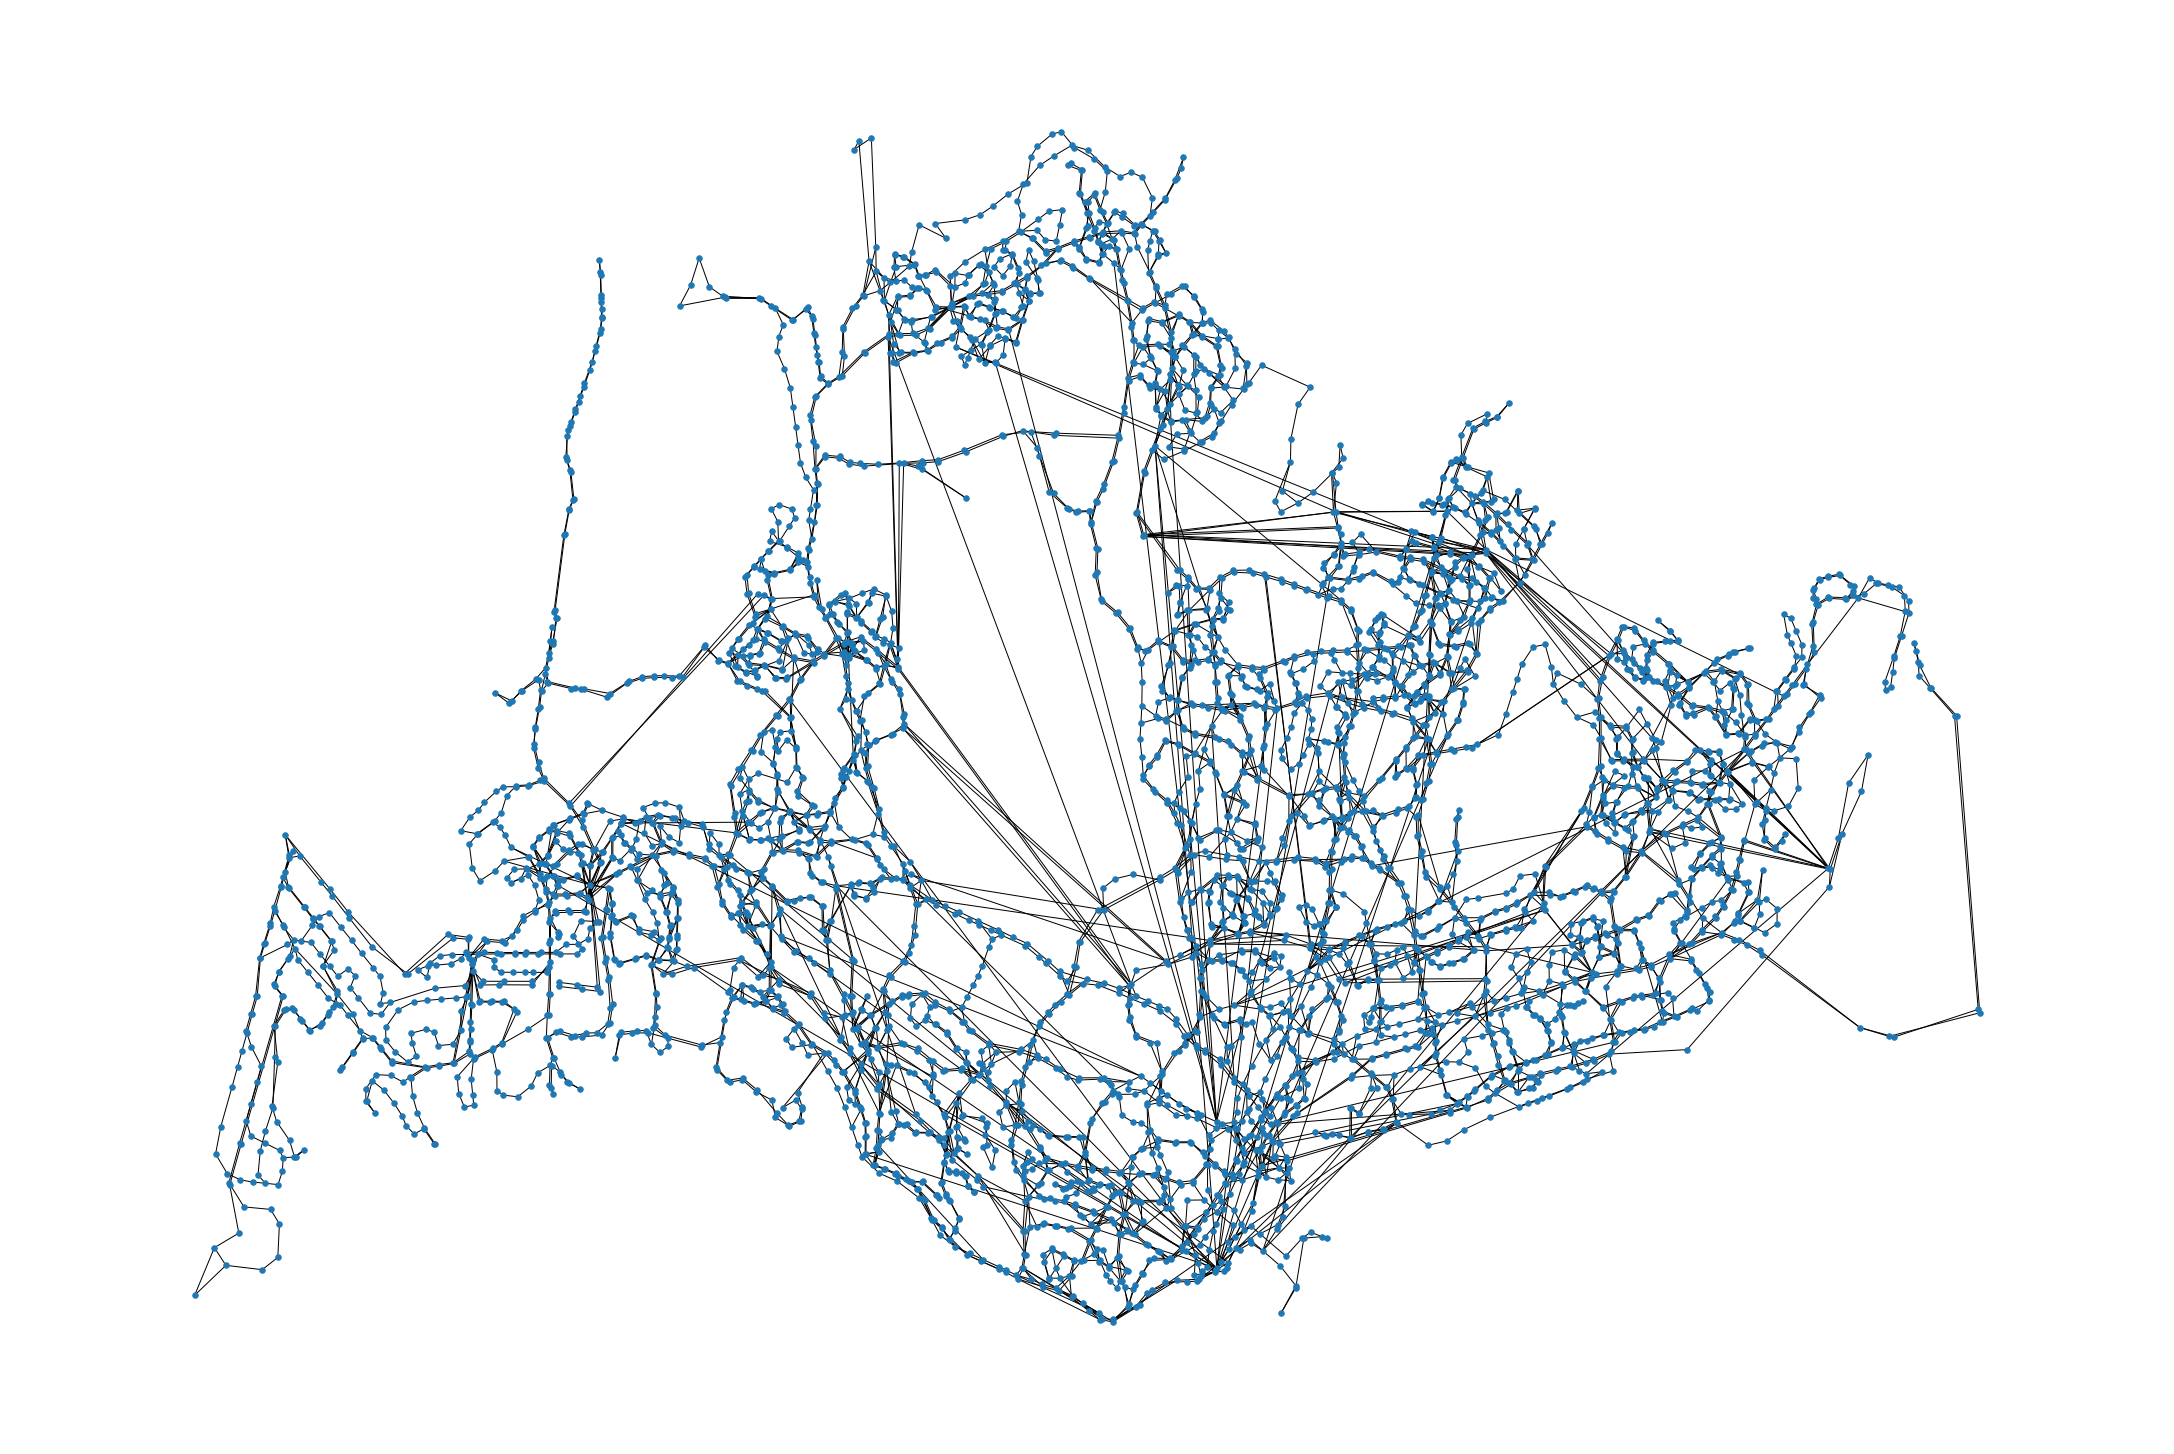

In [11]:
G.remove_edges_from(nx.selfloop_edges(G))  # remove loops; nx can't do k-core with loops
kc = nx.k_core(G, k=2)

plt.figure(figsize=(30,20))
nx.draw(kc,pos,node_size = 30)

...but 3-core is exceedingly small, yielding only 2 core groups. <br>

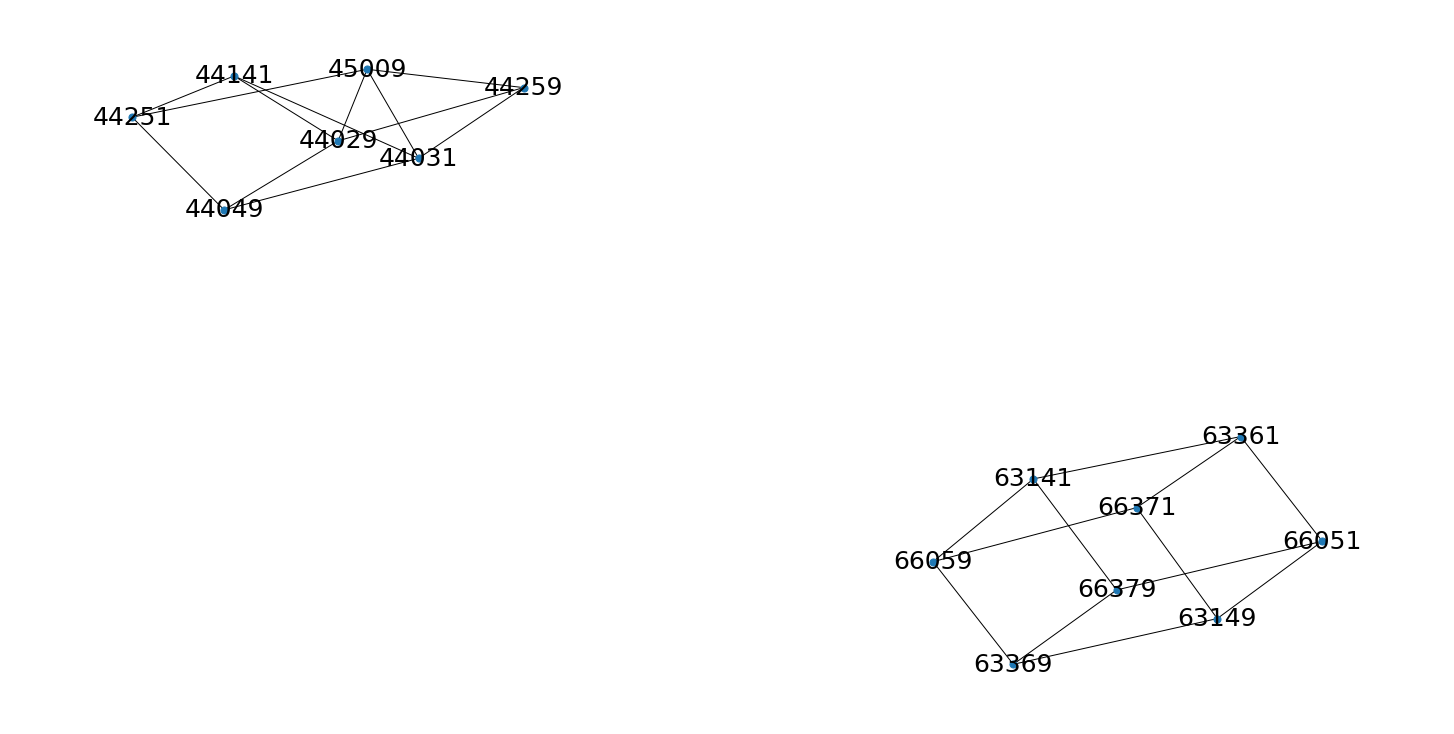

In [12]:
kc = nx.k_core(G, k=3)
pis = nx.spring_layout(kc, k=0.15, iterations=20)

plt.figure(figsize=(20,10))
nx.draw(kc,pis,node_size = 50, with_labels = True, font_size = 25)

Not in lat lon position, spaced out to show the different nodes (bus stops)

### 4c. Edge-Betweeness (Girvan Newman)
Recap: "g" is the igraph object. "G" is the networkx object. <br> Plotting wise, refer to the test paths and edit accordingly

In [7]:
#functions for visualisations

def set_node_com(G, comms):
    for s, t in enumerate(comms):
        for c in t:
            G.nodes[c]['community'] = s + 1
            
def set_edge_community(G):
    for v, b, in G.edges:
        if G.nodes[v]['community'] == G.nodes[b]['community']:
            G.edges[v,b]['community'] = G.nodes[v]['community']
        else:
            G.edges[v,b]['community'] = 0
def colour(i, r_off = 1, g_off = 1, b_off = 1):
    r0, g0, b0 = 0, 0, 0
    n = 16
    low, high = 0.1, 0.9
    span = high - low
    r = low + span * (((i+r_off)*3)%n)/(n-1)
    g = low + span * (((i+g_off)*5)%n)/(n-1)
    b = low + span * (((i+b_off)*7)%n)/(n-1)
    return (r, g, b)

In [13]:
# Re-importing just in case, there are errors if this whole notebook is not run sequentially. 
# Suspect the louvain algorithm module below interferes with this

from networkx.algorithms import community as community

# Find communities
gn = (community.girvan_newman(G))
gn_com = next(itertools.islice(gn, 3, 4))

len(gn_com)

5

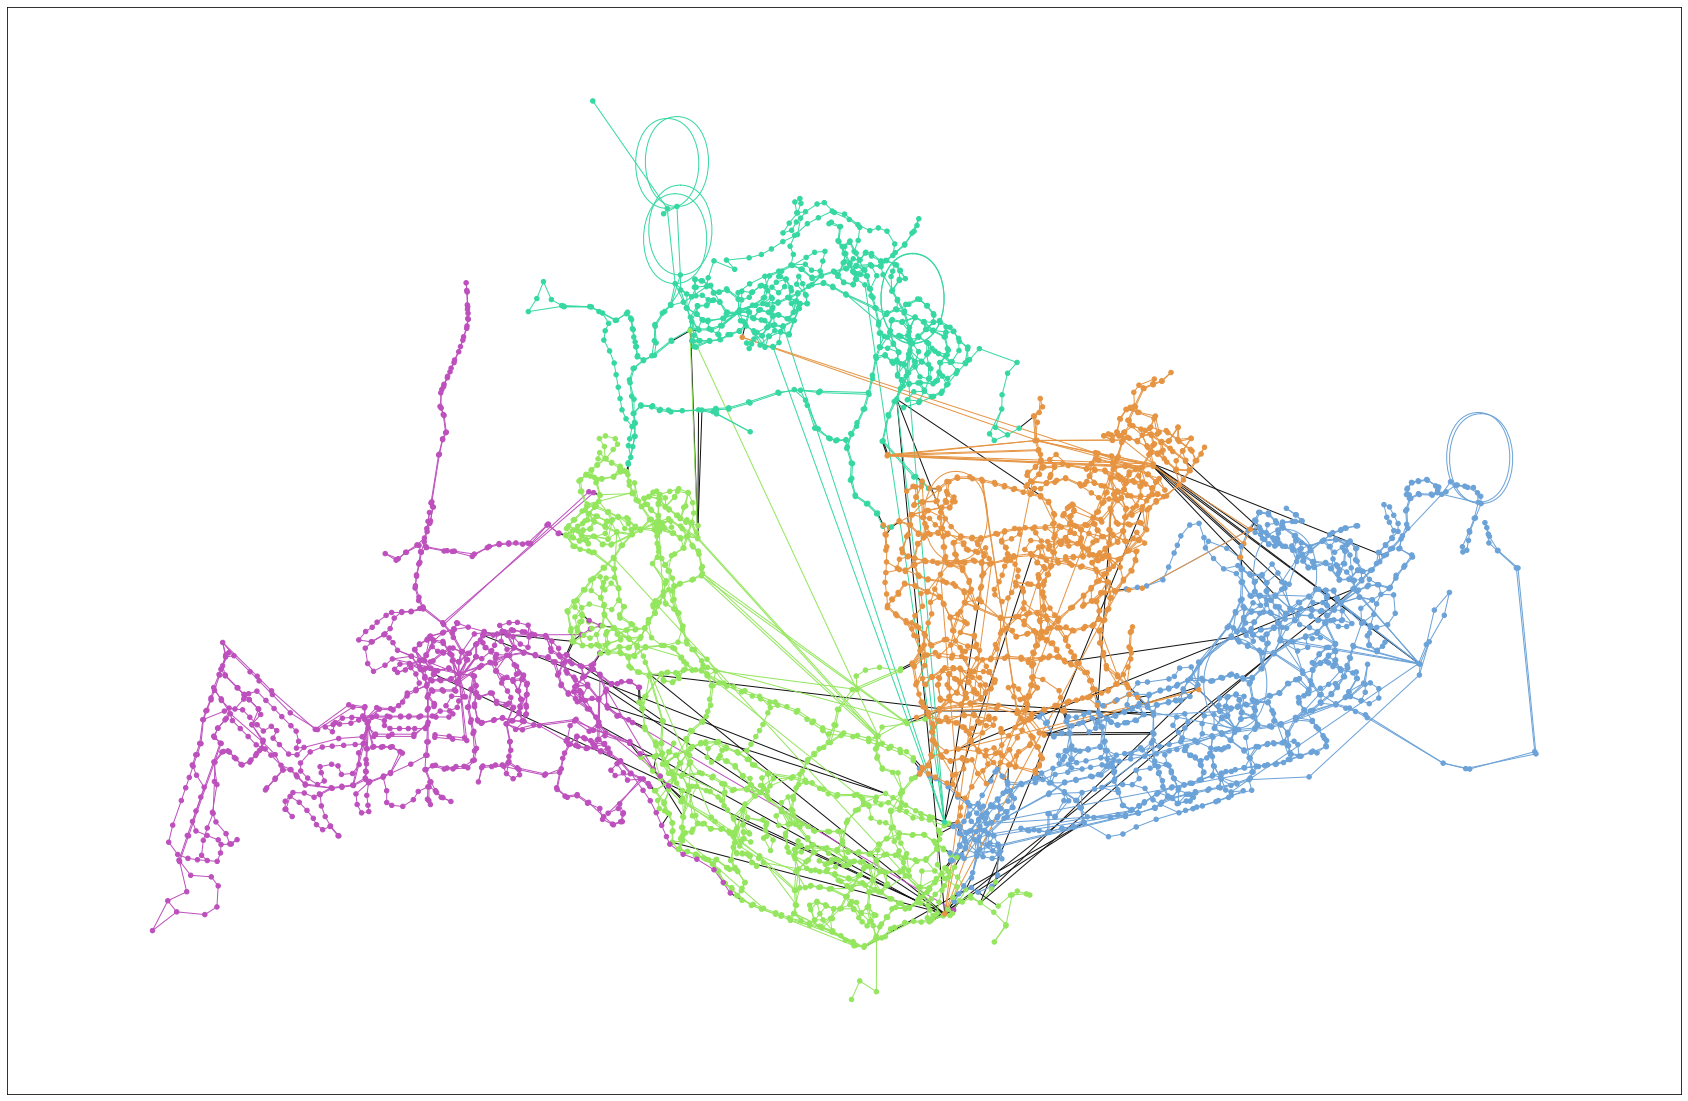

In [28]:
set_node_com(G, gn_com)
set_edge_community(G)
node_colour = [colour(G.nodes[v]['community']) for v in G.nodes]

ext = [(v,w) for v, w in G.edges if G.edges[v,w]['community'] == 0]
internal = [(v,w) for v, w in G.edges if G.edges[v,w]['community'] > 0]
int_colour = [colour(G.edges[c]['community']) for c in internal]

plt.figure(figsize=(30,20))
nx.draw_networkx(G, pos, node_size=0.5,edgelist=ext,edge_color='#111111', with_labels = False)
nx.draw_networkx(G, pos, node_color = node_colour,edgelist=internal,edge_color=int_colour, with_labels = False, node_size=20)
plt.savefig('TDF.png')

In [ ]:
gn_nxcommunity = community.girvan_newman(G)

(WY) I give up here hahaha


(YY) It took forever to run the entire map, will try again tmr

### 4d. Louvain Algorithm 
(WY): Need to find key players next

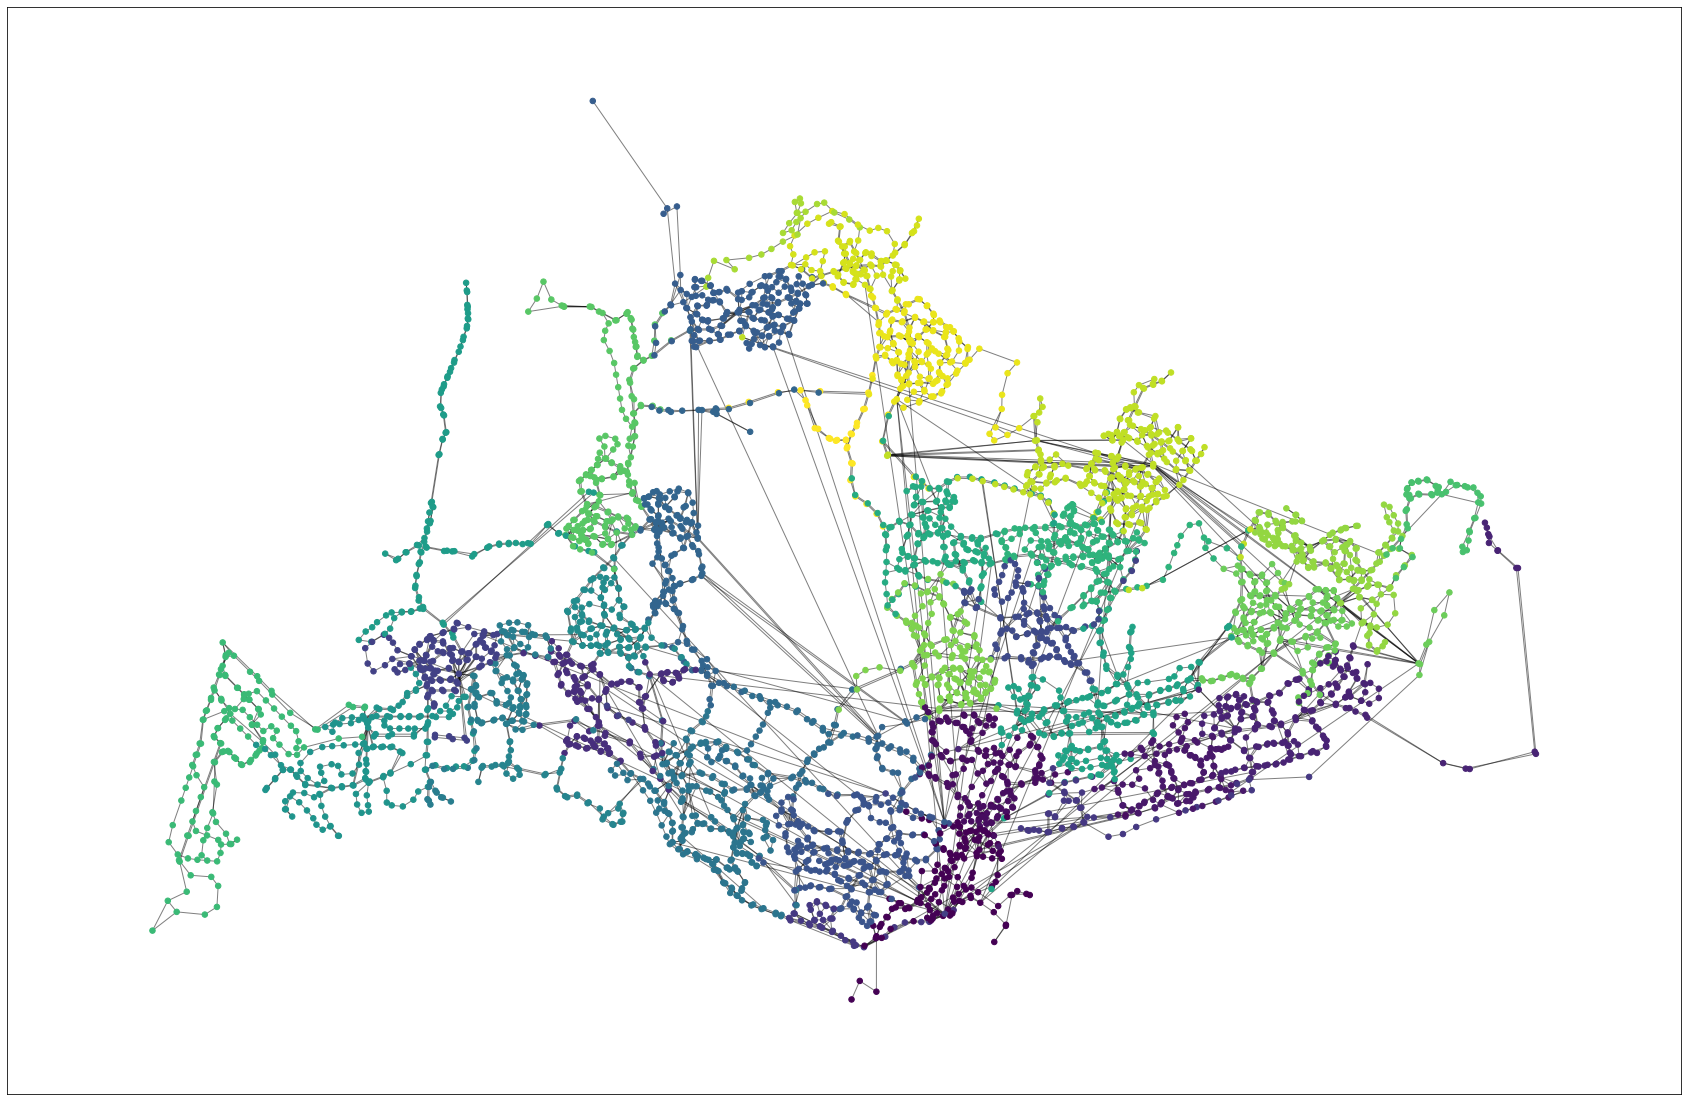

<Figure size 2160x1440 with 0 Axes>

In [15]:
import community.community_louvain as community_louvain
import matplotlib.cm as cm

plt.rcParams['figure.figsize'] = [30,20]

partition =  community_louvain.best_partition(G)
cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=30, cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.figure(figsize=(30,20))
plt.show()

There are 31 partitions in total. The next task would be to find the key player in each of these communities.

In [16]:
# max(partition.values())

31

### 4e. Greedy Modularity
(WY): Need to find key players next

In [17]:
gmc_communities = sorted(community.greedy_modularity_communities(G),key=len,reverse=True)
len(gmc_communities)

32

There are 32 communities.

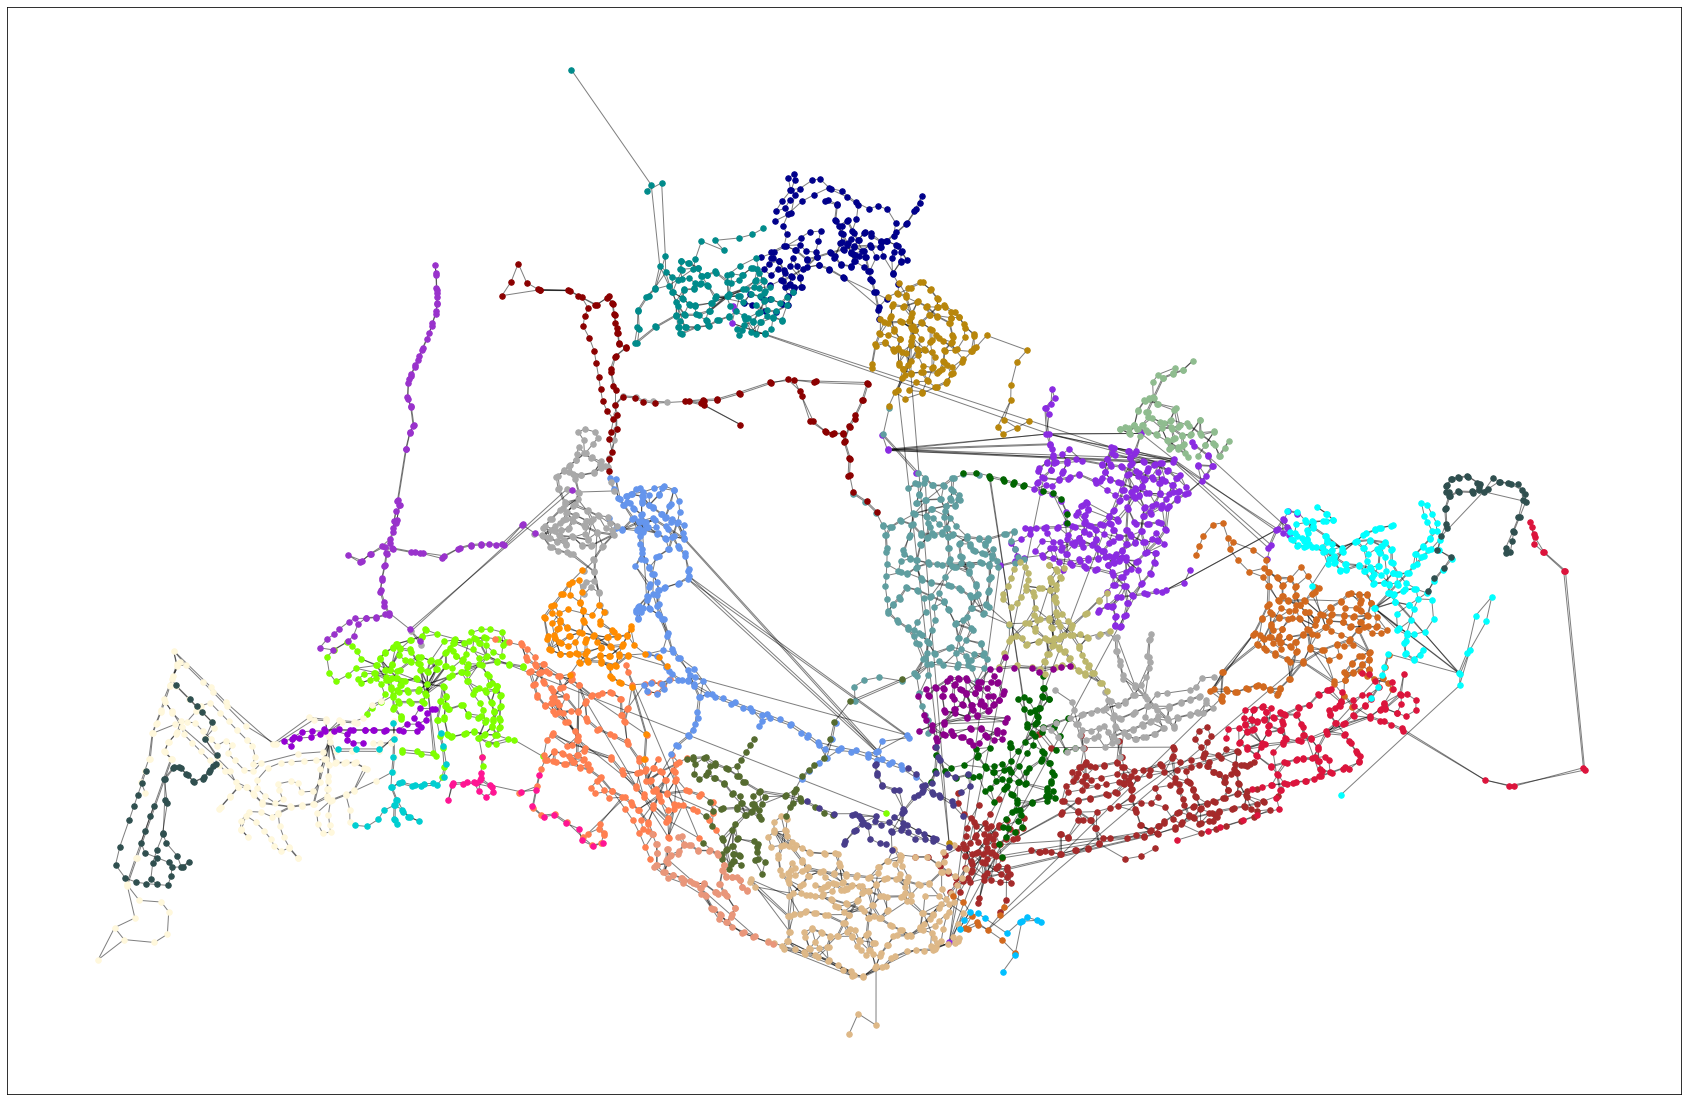

In [18]:
from matplotlib import colors

color_list = list(colors.cnames.values())
        
for i, community in enumerate(gmc_communities):
    subgraph = G.subgraph(community)
    subgraph_pos = nx.spring_layout(subgraph)
    nx.draw_networkx_nodes(subgraph, pos, node_size=30, node_color=color_list[i+10], cmap=plt.cm.jet)
    nx.draw_networkx_edges(subgraph, pos, alpha=0.5)
     
plt.show()

The next task would be to find the key player in each of these communities.

Note: gmc_communities set are already arranged in descending order, i.e. The first community is the largest, the last is the smallest, and so on. In descending order: <br>
Red > Orange > Yellow > Green > purple > black

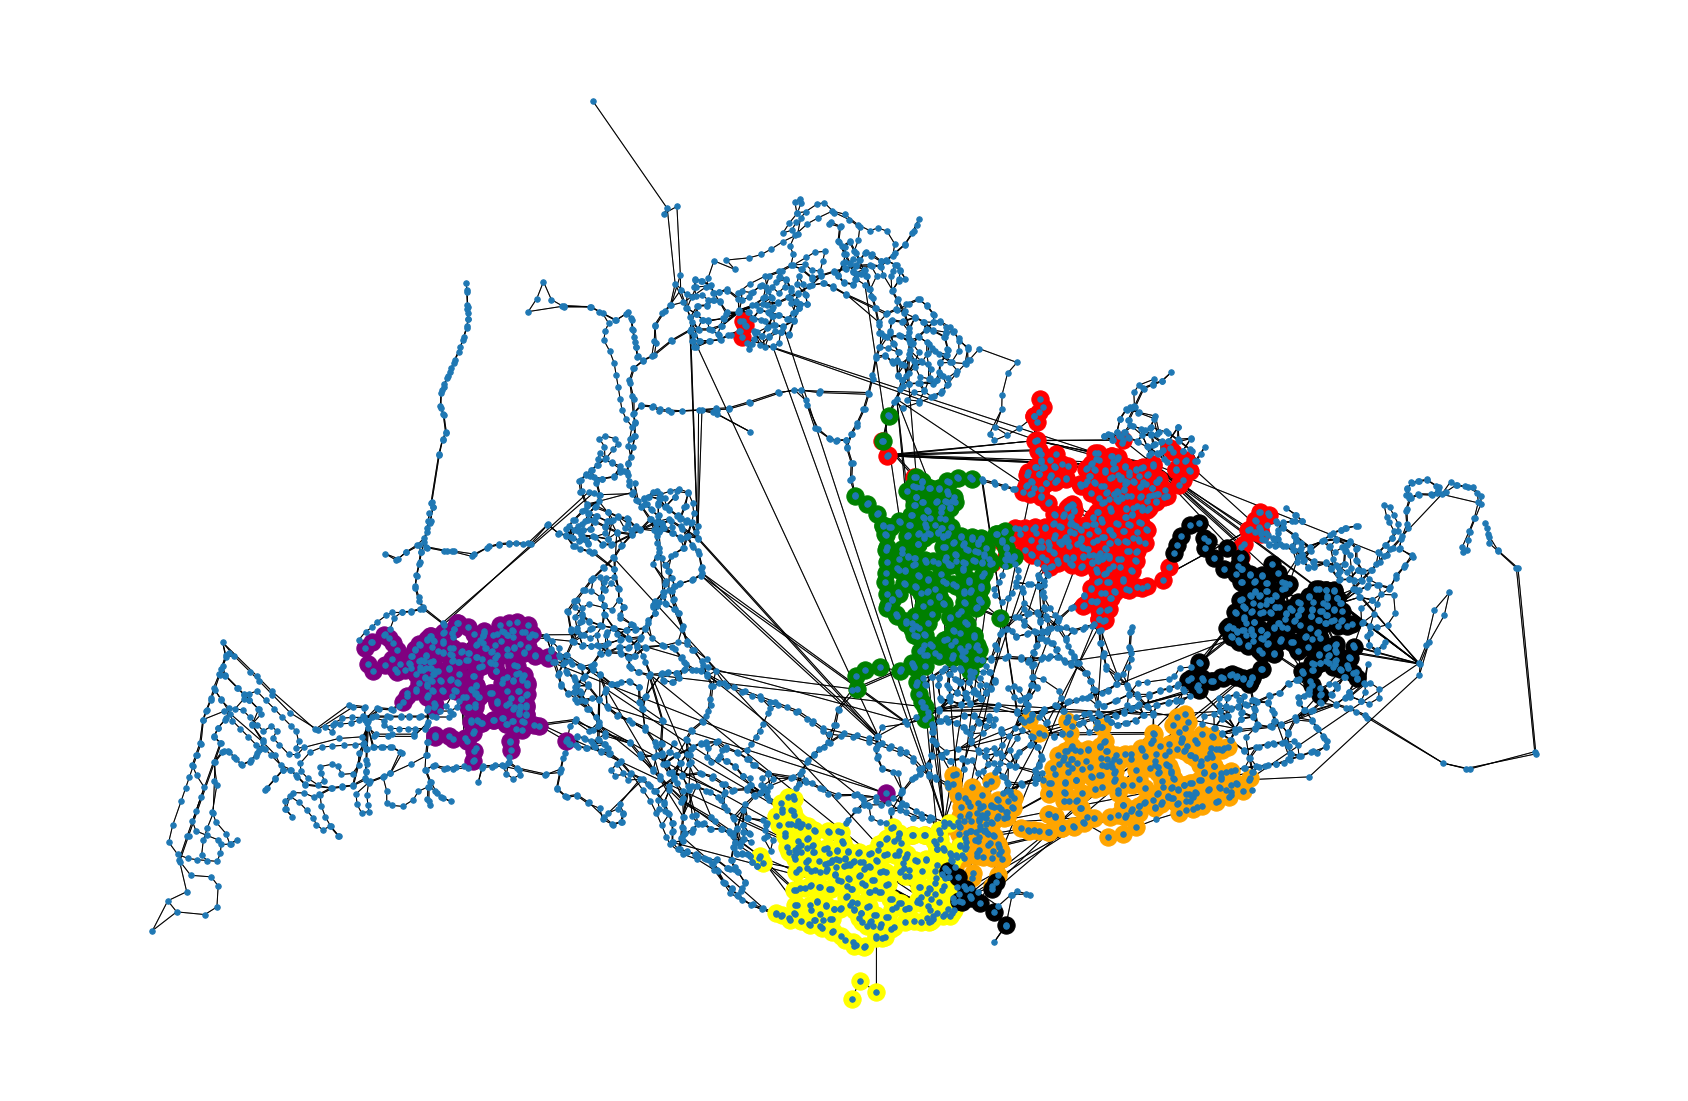

In [23]:
nx.draw_networkx_nodes(G, pos, nodelist=set(list(bus_network.source)).difference(gmc_communities[0:5]), node_color="none")
nx.draw_networkx_nodes(G, pos, nodelist=gmc_communities[0], node_color="red")
nx.draw_networkx_nodes(G, pos, nodelist=gmc_communities[1], node_color="orange")
nx.draw_networkx_nodes(G, pos, nodelist=gmc_communities[2], node_color="yellow")
nx.draw_networkx_nodes(G, pos, nodelist=gmc_communities[3], node_color="green")
nx.draw_networkx_nodes(G, pos, nodelist=gmc_communities[4], node_color="purple")
nx.draw_networkx_nodes(G, pos, nodelist=gmc_communities[5], node_color="black")

nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5)
nx.draw(G,pos,node_size = 30)

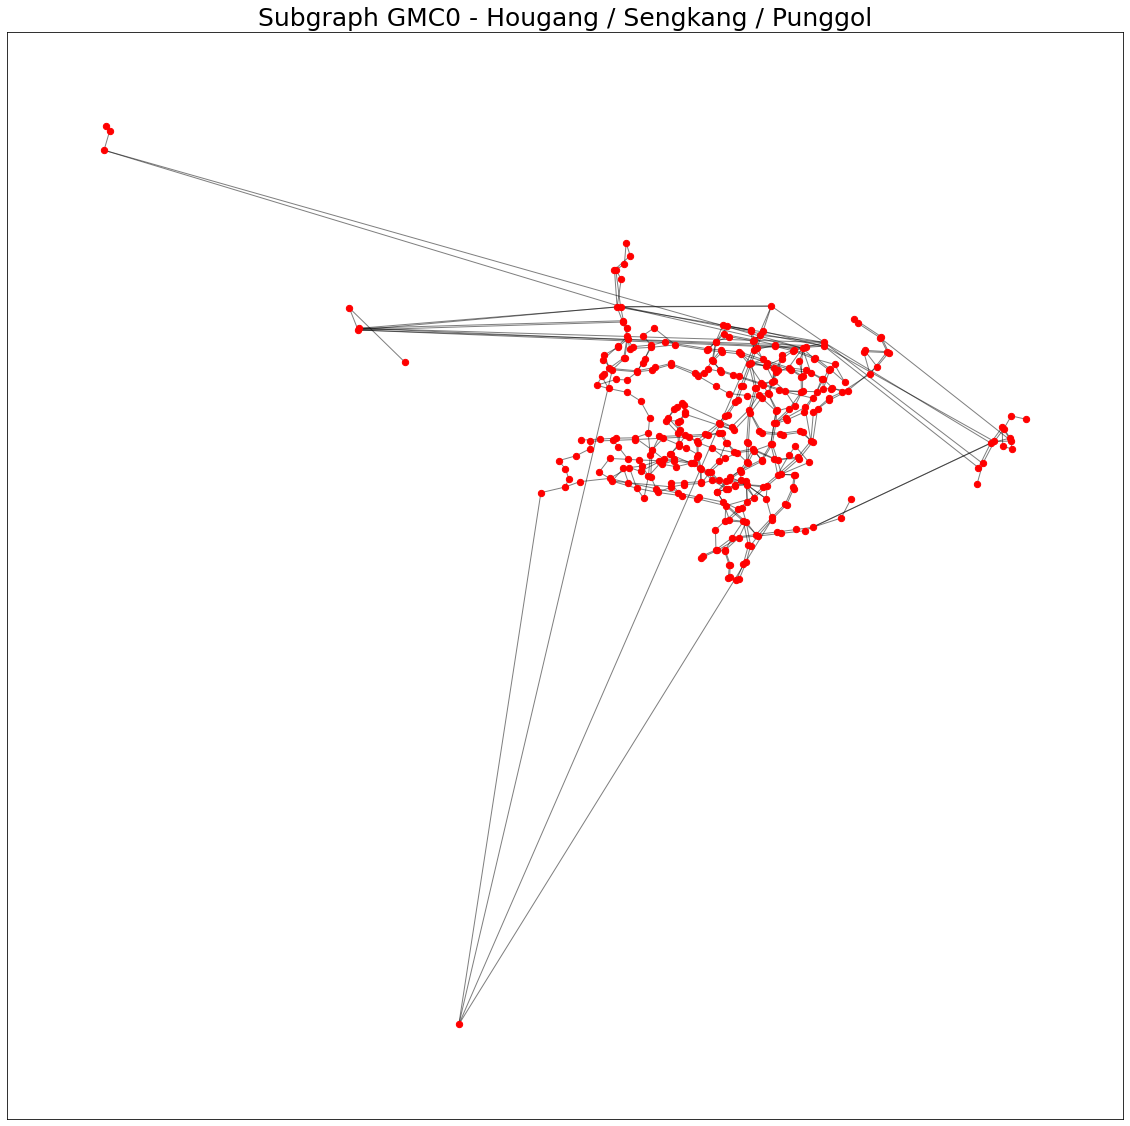

In [26]:
plt.figure(figsize=(20,20))
plt.title("Subgraph GMC0 - Hougang / Sengkang / Punggol", fontsize = 25)
GMC0 = G.subgraph(gmc_communities[0])
nx.draw_networkx_edges(GMC0, pos, width=1.0, alpha=0.5)
nx.draw_networkx_nodes(GMC0, pos, nodelist=GMC0, node_size = 40, node_color='red')

{'03241': Text(103.84537, 1.27456, 'Anson Rd Mapletree Anson'),
 '65431': Text(103.89673562171807, 1.40238938083661, 'Punggol Way Twin Waterfalls'),
 '64239': Text(103.89682349089492, 1.36439805444874, 'Hougang Ave 7 Opp Blk 316'),
 '65199': Text(103.90542736761212, 1.39591721161169, 'TPE Aft Punggol Rd'),
 '67591': Text(103.8953647897483, 1.39790048032037, 'Sengkang East Rd Blk 286B')}

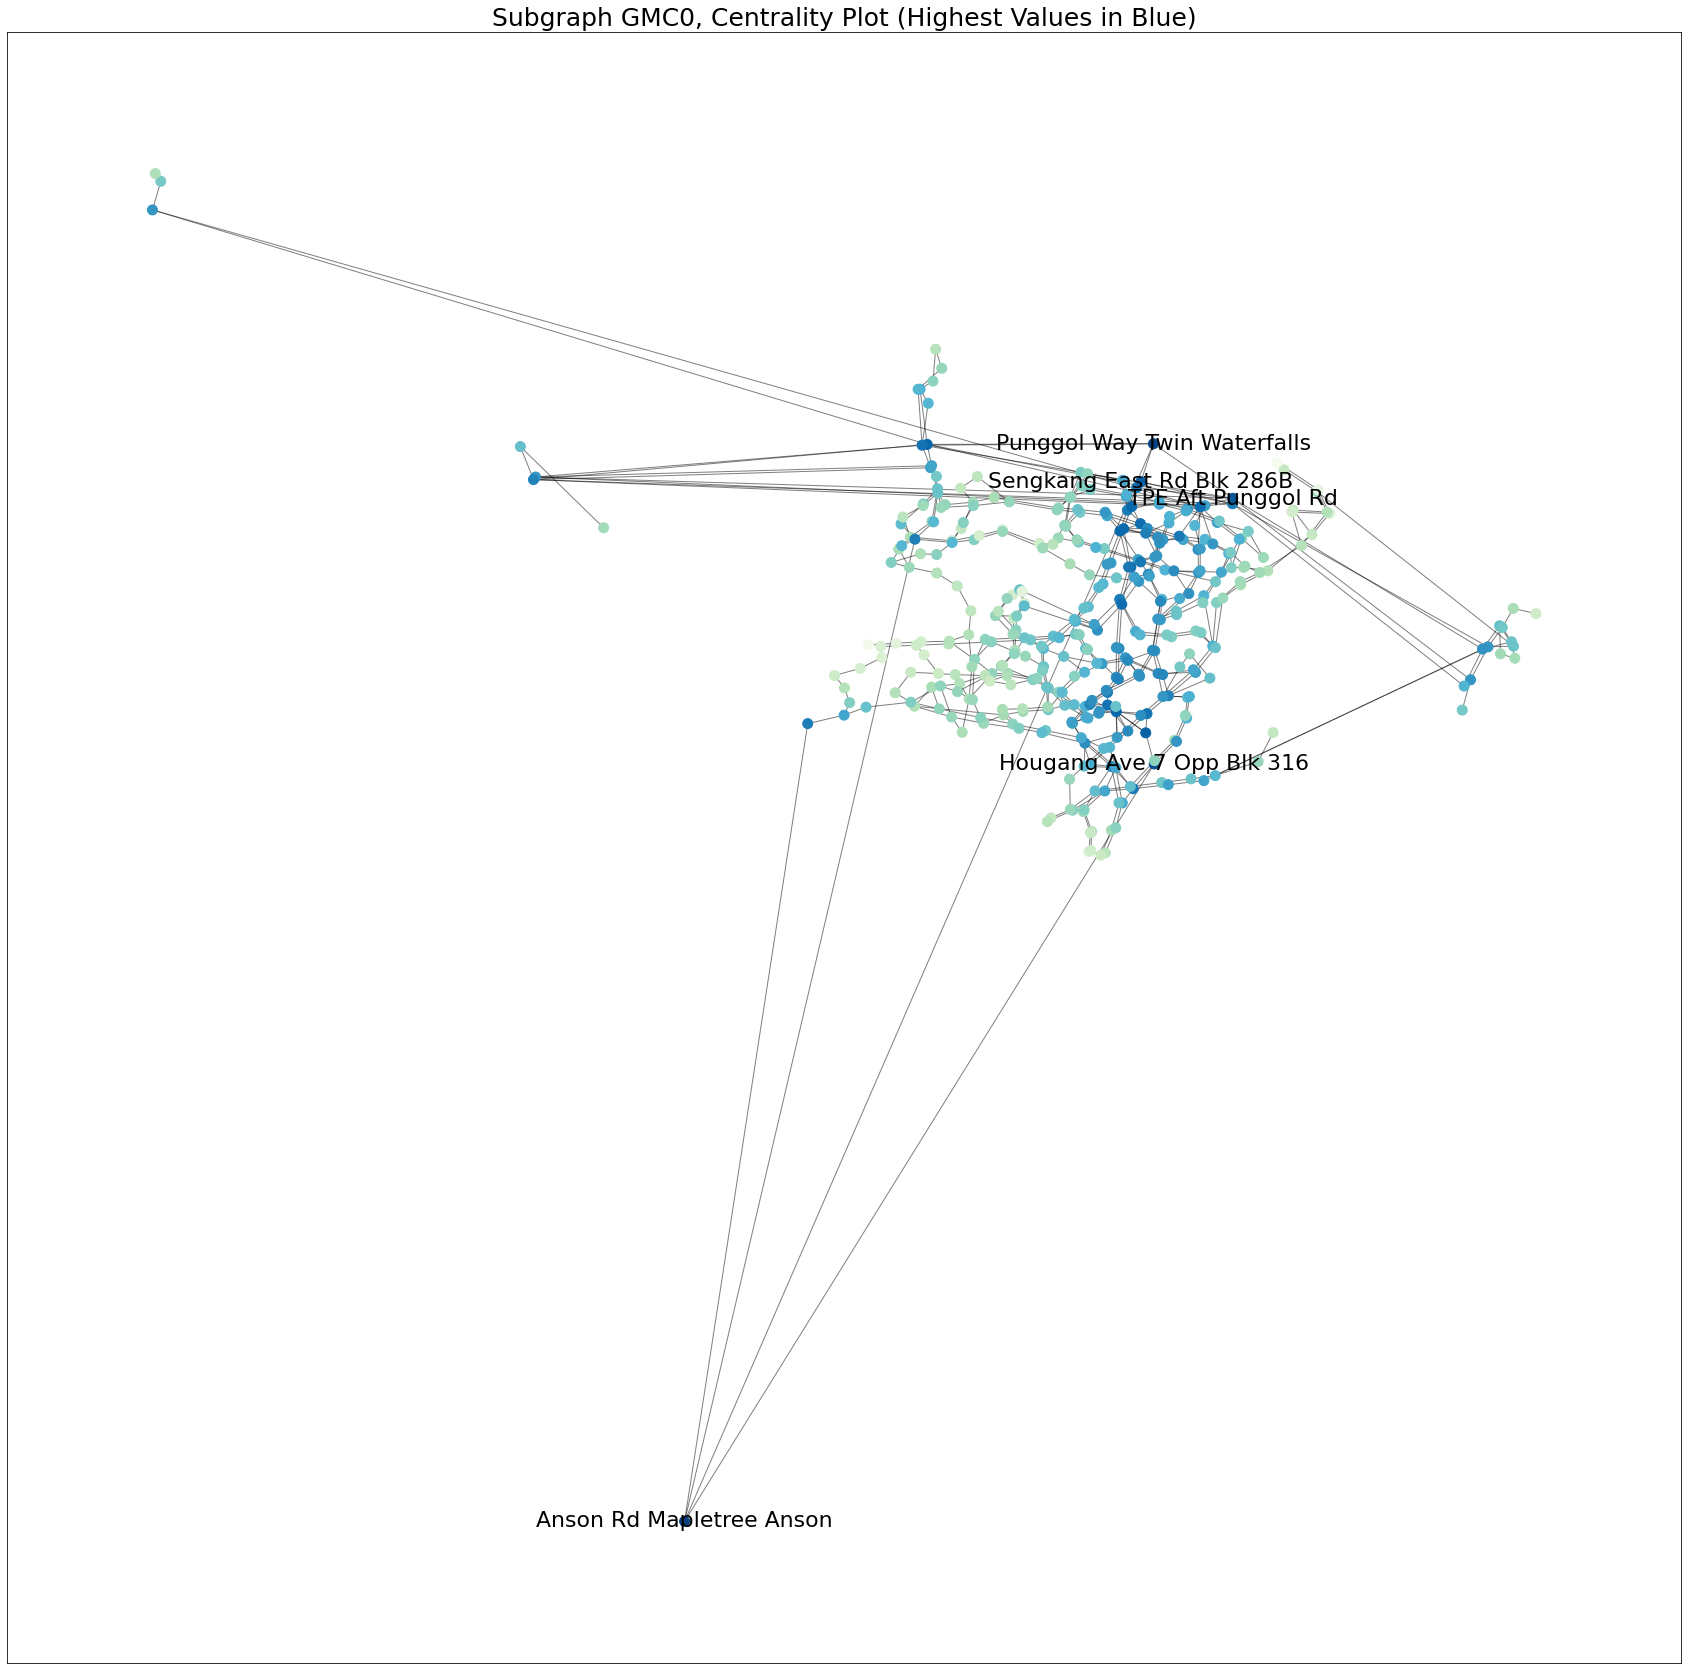

In [25]:
# Using Closeness Centrality to determine the node with the maximum closeness in GMC Community  0 (Red)
GMC0_closeness = nx.closeness_centrality(GMC0)

# Formatting  colour scheme, blue has highest value, light green has lowest
cl_values = list(GMC0_closeness.values())
norm  = [float(i)/max(cl_values) for i in cl_values]
cmap = cm.get_cmap('GnBu')


# Identify the top 10 key players of this cluster
# Sort closeness by values, descending
cl_values_sorted = sorted(cl_values, reverse  = True)

# Create list of top 5 nodes with highest closeness
cl_stops = []
for val in cl_values_sorted[0:5]:
    for key in GMC0_closeness: 
        if GMC0_closeness[key] == val:
            cl_stops.append(key)
            
# Creating their labels (of descriptions)
cl_stops_desc = {}
for key in cl_stops:
    cl_stops_desc[key]=df_stops.loc[df_stops['BusStopCode']==key,['RoadName', 'Description']].to_string(header=False, index=False)
    
# Plotting subgraph GMC0 by Centrality
plt.figure(figsize=(30,30))
plt.title("Subgraph GMC0, Centrality Plot (Highest Values in Blue)", fontsize = 25)
nx.draw_networkx_nodes(GMC0, pos, GMC0_closeness.keys(), node_size=100, cmap=cmap, node_color=norm)
nx.draw_networkx_edges(GMC0, pos, width=1.0, alpha=0.5)
nx.draw_networkx_labels(GMC0, pos, cl_stops_desc, font_size=22)

These nodes make sense and are aligned with the 'axis' cutting along these 3 neighborhoods (Hougang - Sengkang - Punggol)